<a href="https://colab.research.google.com/github/scullzz/news_classification/blob/main/News_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A1

In [1]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")


from datasets import load_dataset

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

SEED = 42
np.random.seed(SEED)

nltk.download("punkt")
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
ds = load_dataset("ag_news")

train_df = ds["train"].to_pandas()
test_df  = ds["test"].to_pandas()

print(train_df.shape, test_df.shape)
train_df.head()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

(120000, 2) (7600, 2)


,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [3]:
label_names = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

train_df["label_name"] = train_df["label"].map(label_names)
test_df["label_name"]  = test_df["label"].map(label_names)

train_df["label_name"].value_counts()


,count
label_name,
Business,30000
Sci/Tech,30000
Sports,30000
World,30000


In [4]:
def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return " ".join(tokens)

# Чтобы не ждать долго в Colab: чистим сначала часть, потом можно весь train
train_df["clean_text"] = train_df["text"].apply(clean_text)
test_df["clean_text"]  = test_df["text"].apply(clean_text)

train_df[["text", "clean_text", "label_name"]].head()


,text,clean_text,label_name
0,Wall St. Bears Claw Back Into the Black (Reute...,wall bears claw back black reuters reuters sho...,Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,carlyle looks toward commercial aerospace reut...,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,oil economy cloud stocks outlook reuters reute...,Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,iraq halts oil exports main southern pipeline ...,Business
4,"Oil prices soar to all-time record, posing new...",oil prices soar alltime record posing new mena...,Business


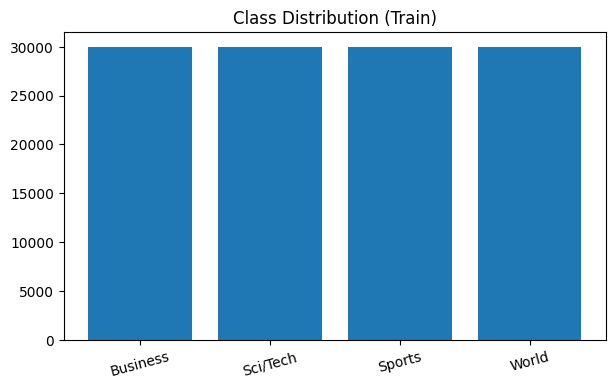

In [5]:
counts = train_df["label_name"].value_counts()

plt.figure(figsize=(7,4))
plt.bar(counts.index, counts.values)
plt.title("Class Distribution (Train)")
plt.xticks(rotation=15)
plt.show()


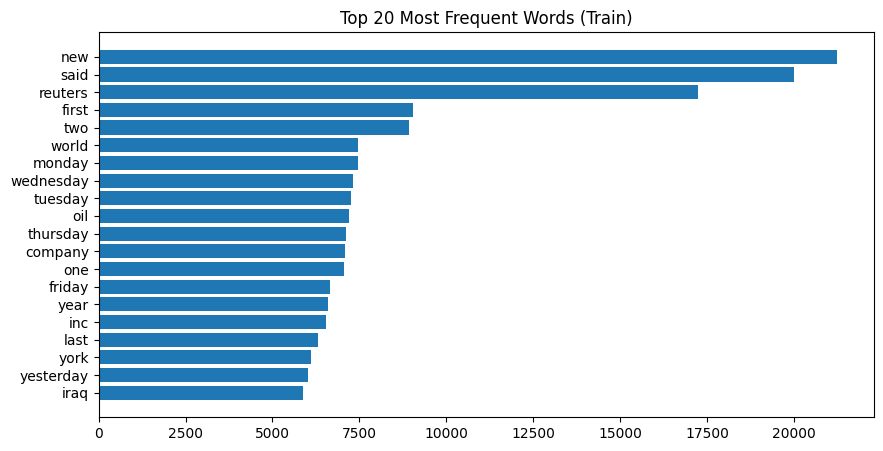

In [6]:
all_words = " ".join(train_df["clean_text"]).split()
freq = pd.Series(all_words).value_counts().head(20)

plt.figure(figsize=(10,5))
plt.barh(freq.index[::-1], freq.values[::-1])
plt.title("Top 20 Most Frequent Words (Train)")
plt.show()


In [7]:
vectorizer = CountVectorizer(max_features=20000, ngram_range=(1,1))

X_train = vectorizer.fit_transform(train_df["clean_text"])
X_test  = vectorizer.transform(test_df["clean_text"])

y_train = train_df["label"]
y_test  = test_df["label"]


In [8]:
baseline_model = LogisticRegression(max_iter=2000, random_state=SEED)
baseline_model.fit(X_train, y_train)

pred = baseline_model.predict(X_test)

acc = accuracy_score(y_test, pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, pred, average="macro")

print("Baseline (BoW + Logistic Regression)")
print("Accuracy:", acc)
print("Macro Precision:", prec)
print("Macro Recall:", rec)
print("Macro F1:", f1)

cm = confusion_matrix(y_test, pred)
print("\nConfusion Matrix:\n", cm)


Baseline (BoW + Logistic Regression)
Accuracy: 0.9051315789473684
Macro Precision: 0.9050743108351786
Macro Recall: 0.9051315789473684
Macro F1: 0.905041226506196

Confusion Matrix:
 [[1701   55   80   64]
 [  31 1844   15   10]
 [  68   18 1648  166]
 [  53   13  148 1686]]


In [9]:
# Сохраняем очищенные данные
train_df.to_csv("ag_news_train_cleaned_A1.csv", index=False)
test_df.to_csv("ag_news_test_cleaned_A1.csv", index=False)

# Сохраняем baseline метрики в файл
metrics_a1 = {
    "model": "BoW + Logistic Regression",
    "accuracy": float(acc),
    "macro_precision": float(prec),
    "macro_recall": float(rec),
    "macro_f1": float(f1)
}
pd.DataFrame([metrics_a1]).to_csv("A1_baseline_metrics.csv", index=False)

print("Saved: ag_news_train_cleaned_A1.csv, ag_news_test_cleaned_A1.csv, A1_baseline_metrics.csv")


Saved: ag_news_train_cleaned_A1.csv, ag_news_test_cleaned_A1.csv, A1_baseline_metrics.csv


# A2

In [10]:
import pandas as pd

train_df = pd.read_csv("ag_news_train_cleaned_A1.csv")
test_df  = pd.read_csv("ag_news_test_cleaned_A1.csv")

X_train_text = train_df["clean_text"]
y_train = train_df["label"]

X_test_text = test_df["clean_text"]
y_test = test_df["label"]

print(train_df.shape, test_df.shape)


(120000, 4) (7600, 4)


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1,2),
    stop_words="english"
)

X_train = tfidf.fit_transform(X_train_text)
X_test  = tfidf.transform(X_test_text)


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

lr = LogisticRegression(max_iter=3000, random_state=42)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

lr_acc = accuracy_score(y_test, lr_pred)
lr_prec, lr_rec, lr_f1, _ = precision_recall_fscore_support(y_test, lr_pred, average="macro")

print("TF-IDF + Logistic Regression")
print("Accuracy:", lr_acc)
print("Macro Precision:", lr_prec)
print("Macro Recall:", lr_rec)
print("Macro F1:", lr_f1)
print("Confusion Matrix:\n", confusion_matrix(y_test, lr_pred))


TF-IDF + Logistic Regression
Accuracy: 0.9196052631578947
Macro Precision: 0.9194142718152739
Macro Recall: 0.9196052631578948
Macro F1: 0.9194265548537306
Confusion Matrix:
 [[1729   55   77   39]
 [  18 1866   11    5]
 [  58   14 1678  150]
 [  48   16  120 1716]]


In [13]:
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

svm_acc = accuracy_score(y_test, svm_pred)
svm_prec, svm_rec, svm_f1, _ = precision_recall_fscore_support(y_test, svm_pred, average="macro")

print("TF-IDF + Linear SVM")
print("Accuracy:", svm_acc)
print("Macro Precision:", svm_prec)
print("Macro Recall:", svm_rec)
print("Macro F1:", svm_f1)
print("Confusion Matrix:\n", confusion_matrix(y_test, svm_pred))


TF-IDF + Linear SVM
Accuracy: 0.9222368421052631
Macro Precision: 0.9221586949275913
Macro Recall: 0.9222368421052631
Macro F1: 0.9220764155453915
Confusion Matrix:
 [[1727   54   75   44]
 [  16 1871    9    4]
 [  53   14 1685  148]
 [  41   14  119 1726]]


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("svm", LinearSVC())
])

param_grid = {
    "tfidf__max_features": [30000, 50000],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "svm__C": [0.5, 1, 2]
}

grid = GridSearchCV(
    pipe,
    param_grid,
    scoring="accuracy",
    cv=3,
    n_jobs=-1
)

grid.fit(X_train_text, y_train)

print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)


Best params: {'svm__C': 0.5, 'tfidf__max_features': 50000, 'tfidf__ngram_range': (1, 2)}
Best CV accuracy: 0.9028999999999999


In [16]:
best_model = grid.best_estimator_
best_pred = best_model.predict(X_test_text)

best_acc = accuracy_score(y_test, best_pred)
best_prec, best_rec, best_f1, _ = precision_recall_fscore_support(y_test, best_pred, average="macro")

print("Best Tuned TF-IDF + Linear SVM")
print("Accuracy:", best_acc)
print("Macro Precision:", best_prec)
print("Macro Recall:", best_rec)
print("Macro F1:", best_f1)
print("Confusion Matrix:\n", confusion_matrix(y_test, best_pred))


Best Tuned TF-IDF + Linear SVM
Accuracy: 0.9242105263157895
Macro Precision: 0.9241903429157692
Macro Recall: 0.9242105263157896
Macro F1: 0.924053667901141
Confusion Matrix:
 [[1731   54   73   42]
 [  10 1876   10    4]
 [  48   14 1688  150]
 [  41   13  117 1729]]


In [17]:
results = pd.DataFrame([
    {"Model": "Assignment 1: BoW + Logistic Regression", "Accuracy": 0.9051},
    {"Model": "Assignment 2: TF-IDF + Logistic Regression", "Accuracy": lr_acc},
    {"Model": "Assignment 2: TF-IDF + Linear SVM", "Accuracy": svm_acc},
    {"Model": "Assignment 2: Tuned TF-IDF + Linear SVM", "Accuracy": best_acc},
])

results


,Model,Accuracy
0,Assignment 1: BoW + Logistic Regression,0.905100
1,Assignment 2: TF-IDF + Logistic Regression,0.919605
2,Assignment 2: TF-IDF + Linear SVM,0.922237
3,Assignment 2: Tuned TF-IDF + Linear SVM,0.924211


In [18]:
import joblib

joblib.dump(best_model, "best_model_A2.pkl")
print("Saved best_model_A2.pkl")


Saved best_model_A2.pkl


# A3

In [19]:
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

ds = load_dataset("ag_news")

label_names = {0:"World", 1:"Sports", 2:"Business", 3:"Sci/Tech"}
ds


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [20]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True)

tokenized = ds.map(tokenize_fn, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenized


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7600
    })
})

In [24]:
import evaluate
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"]}

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=4)

training_args = TrainingArguments(
    output_dir="agnews_distilbert",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=200,
    report_to="none",
    seed=42
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1380216391.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.214200,0.174170,0.944211
2,0.137000,0.187691,0.946053


TrainOutput(global_step=15000, training_loss=0.18173915710449218, metrics={'train_runtime': 2159.6913, 'train_samples_per_second': 111.127, 'train_steps_per_second': 6.945, 'total_flos': 6040323130797312.0, 'train_loss': 0.18173915710449218, 'epoch': 2.0})

In [25]:
eval_res = trainer.evaluate()
eval_res

{'eval_loss': 0.17417046427726746,
 'eval_accuracy': 0.9442105263157895,
 'eval_runtime': 23.9799,
 'eval_samples_per_second': 316.932,
 'eval_steps_per_second': 9.925,
 'epoch': 2.0}

In [26]:
final_acc = eval_res["eval_accuracy"]

chain_table = pd.DataFrame([
    {"Stage":"Baseline (A1)", "Model":"BoW + Logistic Regression", "Accuracy":0.905100},
    {"Stage":"Improved (A2)", "Model":"Tuned TF-IDF + Linear SVM", "Accuracy":0.924211},
    {"Stage":"Final", "Model":"DistilBERT (Transformer)", "Accuracy":final_acc},
])

chain_table


,Stage,Model,Accuracy
0,Baseline (A1),BoW + Logistic Regression,0.905100
1,Improved (A2),Tuned TF-IDF + Linear SVM,0.924211
2,Final,DistilBERT (Transformer),0.944211


In [27]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

best_model = joblib.load("best_model_A2.pkl")

tfidf_vec = best_model.named_steps["tfidf"]
svm_clf = best_model.named_steps["svm"]

feature_names = np.array(tfidf_vec.get_feature_names_out())

def top_words_for_class(class_id, topn=15):
    coef = svm_clf.coef_[class_id]
    top_idx = np.argsort(coef)[-topn:][::-1]
    return feature_names[top_idx]

for cid in range(4):
    print("\nClass:", label_names[cid])
    print(", ".join(top_words_for_class(cid, 15)))



Class: World
canadian press, york stocks, iraq, athens greece, afp afp, ltpgtltpgtltpgt, darfur, iraqi, arafat, afp, palestinian, nuclear, hostage, iraqis, terrorism

Class: Sports
coach, nba, cup, sports, stadium, nascar, team, baseball, league, formula, players, nfl, bryant, nhl, basketball

Class: Business
hellip, lta, cbsmw, enron, economy, dow, investing, halliburton, york reuters, bank, martha, airlines, adv, economic, oil

Class: Sci/Tech
nasa, oracles, internet, space, reuters reuters, evoting, linux, wifi, scientists, software, science, ftcom, apple, washingtonpostcom, wired magazine


In [29]:
import torch

device = trainer.model.device  # cpu или cuda

def predict_news_category(text: str):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # ← ВАЖНО

    with torch.no_grad():
        outputs = trainer.model(**inputs)
        logits = outputs.logits

    pred = int(torch.argmax(logits, dim=1).item())
    return pred, label_names[pred]



In [30]:
while True:
    text = input("\nEnter a news article (or 'exit'): ")
    if text.lower() == "exit":
        break
    cid, name = predict_news_category(text)
    print(f"Predicted category: {name}")



Enter a news article (or 'exit'): NASA launches a new satellite to study climate change.
Predicted category: Sci/Tech

Enter a news article (or 'exit'): Stock markets rise as tech companies report strong earnings
Predicted category: Business

Enter a news article (or 'exit'): The president met with foreign leaders to discuss peace talks
Predicted category: World

Enter a news article (or 'exit'): exit


In [32]:
import ipywidgets as widgets
from IPython.display import display

text_box = widgets.Textarea(
    placeholder="Paste a news article here...",
    layout=widgets.Layout(width="80%", height="120px")
)

output = widgets.Output()

def on_button_click(b):
    with output:
        output.clear_output()
        text = text_box.value
        cid, name = predict_news_category(text)
        print("Predicted category:", name)

button = widgets.Button(description="Classify News")
button.on_click(on_button_click)

display(text_box, button, output)


Textarea(value='', layout=Layout(height='120px', width='80%'), placeholder='Paste a news article here...')

Button(description='Classify News', style=ButtonStyle())

Output()